In [301]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

np.random.seed(123)
tf.random.set_seed(123)

In [302]:
df=pd.read_csv('./HDFC.csv',index_col='Date',parse_dates=True)

Data Pre processing


In [303]:
df

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2000-01-03,HDFC,EQ,271.75,293.50,293.50,293.50,293.50,293.50,293.50,22744,6.675364e+11,NaN,NaN,NaN
2000-01-04,HDFC,EQ,293.50,317.00,317.00,297.00,304.00,304.05,303.62,255251,7.749972e+12,NaN,NaN,NaN
2000-01-05,HDFC,EQ,304.05,290.00,303.90,285.00,295.00,292.80,294.53,269087,7.925368e+12,NaN,NaN,NaN
2000-01-06,HDFC,EQ,292.80,301.00,314.00,295.00,296.00,296.45,300.14,305916,9.181669e+12,NaN,NaN,NaN
2000-01-07,HDFC,EQ,296.45,290.00,296.35,281.00,287.10,286.55,288.80,197039,5.690480e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,HDFC,EQ,2497.35,2500.00,2534.10,2483.20,2502.00,2509.80,2508.07,3916088,9.821805e+14,121028.0,2440395.0,0.6232
2021-04-27,HDFC,EQ,2509.80,2494.15,2526.80,2486.25,2514.00,2518.40,2509.18,2040799,5.120730e+14,102250.0,1040749.0,0.5100
2021-04-28,HDFC,EQ,2518.40,2516.10,2609.00,2508.30,2575.00,2577.00,2574.21,3407461,8.771527e+14,117425.0,1815110.0,0.5327


In [304]:
df['Date']=df.index

In [305]:
start_date='2020-01-01'
end_date='2020-12-31'
mask=(df['Date']>=start_date)&(df['Date']<=end_date)

In [306]:
df=df.loc[mask]

In [307]:
df=df.loc[mask]

In [308]:
df=df.drop(columns=['Series','Symbol','Open','High','Low','Last','Close','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble','Date'])

In [309]:
Ntest=math.trunc(0.3*len(df))
train=df.iloc[:-Ntest]
test=df.iloc[-Ntest:]

In [310]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

In [311]:
df['Diff Prev Close']=df['Prev Close'].diff()

In [312]:
series=df['Diff Prev Close'].dropna().to_numpy()

T=50
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)

X=np.array(X).reshape(-1,T)
Y=np.array(Y)
N=len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (201, 50) Y.shape (201,)


In [313]:
Xtrain,Ytrain=X[:-Ntest],Y[:-Ntest]
Xtest,Ytest=X[-Ntest:],Y[-Ntest:]

ANN

In [314]:
i=Input(shape=(T,))
x=Dense(400,activation='relu')(i)
x=Dense(100,activation='relu')(x)
x=Dense(50,activation='relu')(x)
x=Dense(1,activation='relu')(x)
model_ann=Model(i,x)
model_ann.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_55 (Dense)            (None, 400)               20400     
                                                                 
 dense_56 (Dense)            (None, 100)               40100     
                                                                 
 dense_57 (Dense)            (None, 50)                5050      
                                                                 
 dense_58 (Dense)            (None, 1)                 51        
                                                                 
Total params: 65,601
Trainable params: 65,601
Non-trainable params: 0
_________________________________________________________________


In [315]:
model_ann.compile(
    loss='mse',
    optimizer='adamax',
    metrics='mae'
)

In [316]:
r=model_ann.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 0s 46ms/step - loss: 4578.1890 - mae: 46.3484 - val_loss: 1844.2164 - val_mae: 31.8461
Epoch 2/100
4/4 [==============================] - 0s 10ms/step - loss: 4389.7676 - mae: 45.7411 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 3/100
4/4 [==============================] - 0s 10ms/step - loss: 4371.3091 - mae: 45.5660 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 4367.2856 - mae: 45.5136 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 5/100
4/4 [==============================] - 0s 9ms/step - loss: 4357.5674 - mae: 45.2523 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 6/100
4/4 [==============================] - 0s 8ms/step - loss: 4358.1255 - mae: 45.3040 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 4358.4365 - mae: 45.3201 - val_loss: 1845.3523 - val_mae: 31.8613
Epoch 8/100
4/4 [===================

CNN

In [317]:
i=Input(shape=(T,1))
x=Conv1D(25,3,activation='relu')(i)
x=MaxPooling1D(2)(x)
x=Conv1D(50,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1)(x)
model_cnn=Model(i,x)
model_cnn.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 48, 25)            100       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 24, 25)           0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 22, 50)            3800      
                                                                 
 global_max_pooling1d_15 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_59 (Dense)            (None, 1)                 51 

In [318]:
model_cnn.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [319]:
r=model_cnn.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest)
)

Epoch 1/100
4/4 [==============================] - 1s 66ms/step - loss: 6682.9326 - mae: 59.2014 - mse: 6682.9326 - val_loss: 1894.6177 - val_mae: 31.9745 - val_mse: 1894.6177
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 4830.4946 - mae: 49.1504 - mse: 4830.4946 - val_loss: 1776.6715 - val_mae: 31.5894 - val_mse: 1776.6715
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 4730.4902 - mae: 49.3206 - mse: 4730.4902 - val_loss: 1791.5017 - val_mae: 32.0353 - val_mse: 1791.5017
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 4788.0479 - mae: 49.5341 - mse: 4788.0479 - val_loss: 1783.7871 - val_mae: 31.8886 - val_mse: 1783.7871
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 4657.4297 - mae: 48.6321 - mse: 4657.4297 - val_loss: 1771.6359 - val_mae: 31.4698 - val_mse: 1771.6359
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 4481.2876 - mae: 47.4094 - mse: 4481.2876 - val_

LSTM

In [320]:
i=Input(shape=(T,1))
x=LSTM(200,return_sequences=True)(i)
x=LSTM(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_lstm=Model(i,x)
model_lstm.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 50, 1)]           0         
                                                                 
 lstm_10 (LSTM)              (None, 50, 200)           161600    
                                                                 
 lstm_11 (LSTM)              (None, 50, 200)           320800    
                                                                 
 global_max_pooling1d_16 (Gl  (None, 200)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_60 (Dense)            (None, 100)               20100     
                                                                 
 dense_61 (Dense)            (None, 50)                5050      
                                                          

In [321]:
check_point_lstm=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [322]:
model_lstm.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [323]:
r=model_lstm.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_lstm]
)

Epoch 1/100
4/4 [==============================] - 4s 418ms/step - loss: 4418.7876 - mae: 45.9309 - mse: 4418.7876 - val_loss: 1895.7131 - val_mae: 32.2888 - val_mse: 1895.7131
Epoch 2/100
4/4 [==============================] - 1s 203ms/step - loss: 4392.9336 - mae: 45.7259 - mse: 4392.9336 - val_loss: 1874.7496 - val_mae: 32.1073 - val_mse: 1874.7496
Epoch 3/100
4/4 [==============================] - 1s 208ms/step - loss: 4388.2622 - mae: 45.7388 - mse: 4388.2622 - val_loss: 1871.1857 - val_mae: 32.0751 - val_mse: 1871.1857
Epoch 4/100
4/4 [==============================] - 1s 212ms/step - loss: 4386.3506 - mae: 45.7189 - mse: 4386.3506 - val_loss: 1869.5356 - val_mae: 32.0620 - val_mse: 1869.5356
Epoch 5/100
4/4 [==============================] - 1s 189ms/step - loss: 4383.4365 - mae: 45.7079 - mse: 4383.4365 - val_loss: 1873.6079 - val_mae: 32.0999 - val_mse: 1873.6079
Epoch 6/100
4/4 [==============================] - 1s 195ms/step - loss: 4381.6636 - mae: 45.6923 - mse: 4381.6636 

GRU

In [324]:
i=Input(shape=(T,1))
x=GRU(200,return_sequences=True)(i)
x=GRU(200,return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(100)(x)
x=Dense(50)(x)
x=Dense(1)(x)
model_gru=Model(i,x)
model_gru.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fe988c79c90>>

In [325]:
check_point_gru=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True)

In [326]:
model_gru.compile(loss='mse',
              optimizer='adamax',
              metrics=['mae','mse'])

In [327]:
r=model_gru.fit(
    Xtrain,
    Ytrain,
    epochs=100,
    validation_data=(Xtest,Ytest),
    callbacks=[check_point_gru]
)

Epoch 1/100
4/4 [==============================] - 5s 419ms/step - loss: 4451.4585 - mae: 46.1424 - mse: 4451.4585 - val_loss: 1974.4233 - val_mae: 32.8959 - val_mse: 1974.4233
Epoch 2/100
4/4 [==============================] - 1s 193ms/step - loss: 4400.6196 - mae: 45.7984 - mse: 4400.6196 - val_loss: 1892.2432 - val_mae: 32.2430 - val_mse: 1892.2432
Epoch 3/100
4/4 [==============================] - 1s 181ms/step - loss: 4384.0308 - mae: 45.8233 - mse: 4384.0308 - val_loss: 1868.6418 - val_mae: 32.0650 - val_mse: 1868.6418
Epoch 4/100
4/4 [==============================] - 1s 193ms/step - loss: 4379.2520 - mae: 45.7714 - mse: 4379.2520 - val_loss: 1860.5770 - val_mae: 32.0071 - val_mse: 1860.5770
Epoch 5/100
4/4 [==============================] - 1s 174ms/step - loss: 4370.9087 - mae: 45.7368 - mse: 4370.9087 - val_loss: 1873.9738 - val_mae: 32.1169 - val_mse: 1873.9738
Epoch 6/100
4/4 [==============================] - 1s 171ms/step - loss: 4366.6919 - mae: 45.6867 - mse: 4366.6919 

Predictions

In [328]:
train_idx[:T+1]=False

In [329]:
Ptrain_ann=model_ann.predict(Xtrain).flatten()
Ptest_ann=model_ann.predict(Xtest).flatten()


In [330]:
Ptrain_cnn=model_cnn.predict(Xtrain).flatten()
Ptest_cnn=model_cnn.predict(Xtest).flatten()

In [331]:
Ptrain_lstm=model_lstm.predict(Xtrain).flatten()
Ptest_lstm=model_lstm.predict(Xtest).flatten()

In [332]:
Ptrain_gru=model_gru.predict(Xtrain).flatten()
Ptest_gru=model_gru.predict(Xtest).flatten()

In [333]:
df.loc[train_idx,'Diff ANN train prediction']=Ptrain_ann
df.loc[test_idx,'Diff ANN test prediction']=Ptest_ann

In [334]:
df.loc[train_idx,'Diff CNN train prediction']=Ptrain_cnn
df.loc[test_idx,'Diff CNN test prediction']=Ptest_cnn

In [335]:
df.loc[train_idx,'Diff LSTM train prediction']=Ptrain_lstm
df.loc[test_idx,'Diff LSTM test prediction']=Ptest_lstm

In [336]:
df.loc[train_idx,'Diff GRU train prediction']=Ptrain_gru
df.loc[test_idx,'Diff GRU test prediction']=Ptest_gru

In [337]:
df['Shift Prev Close']=df['Prev Close'].shift(1)
prev=df['Shift Prev Close']

In [338]:
last_train=train.iloc[-1]['Prev Close']

In [339]:
df.loc[train_idx,'train_ANN']=prev[train_idx]+Ptrain_ann
df.loc[test_idx,'Prediction_ANN']=prev[test_idx]+Ptest_ann

In [340]:
df.loc[train_idx,'train_CNN']=prev[train_idx]+Ptrain_cnn
df.loc[test_idx,'Prediction_CNN']=prev[test_idx]+Ptest_cnn

In [341]:
df.loc[train_idx,'train_LSTM']=prev[train_idx]+Ptrain_lstm
df.loc[test_idx,'Prediction_LSTM']=prev[test_idx]+Ptest_lstm

In [342]:
df.loc[train_idx,'train_GRU']=prev[train_idx]+Ptrain_gru
df.loc[test_idx,'Prediction_GRU']=prev[test_idx]+Ptest_gru

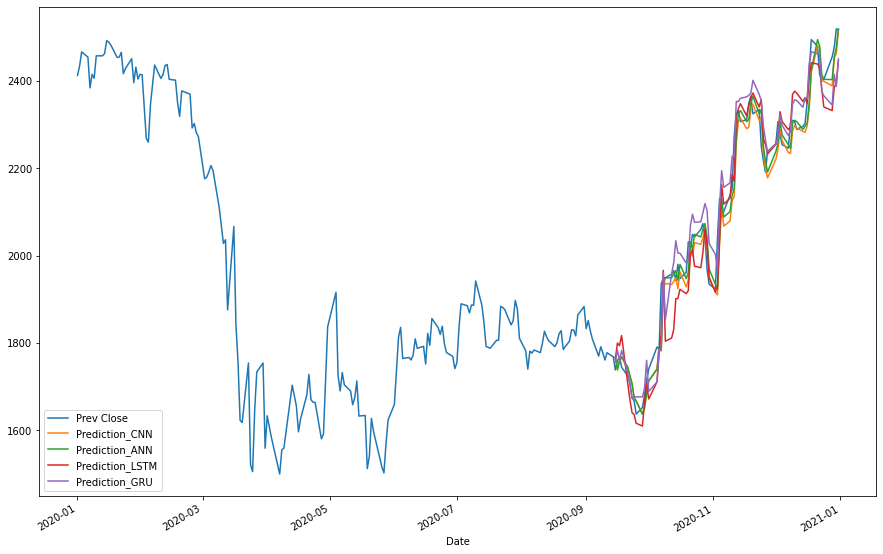

In [343]:
df[[ 'Prev Close','Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10));

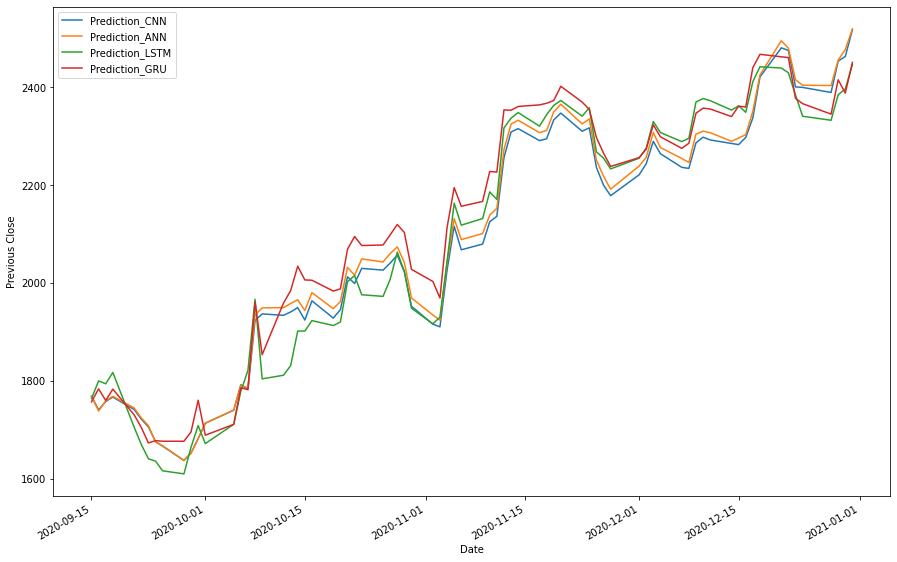

In [344]:
df[[ 'Prediction_CNN','Prediction_ANN','Prediction_LSTM','Prediction_GRU']].plot(figsize=(15,10),
    ylabel=("Previous Close"));

Evaluation

In [345]:
pred_ann=df['Prediction_ANN']
pred_ann.dropna(inplace=True)

In [346]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_ann))
print(rmse)

42.95756355598706


In [347]:
error=mean_absolute_error(test['Prev Close'],pred_ann)
print(error)

31.86133333333333


In [348]:
r2_score(test['Prev Close'],pred_ann)

0.9710893885352849

In [349]:
pred_cnn=df['Prediction_CNN']
pred_cnn.dropna(inplace=True)

In [350]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_cnn))
print(rmse)

47.17168557186132


In [351]:
error=mean_absolute_error(test['Prev Close'],pred_cnn)
print(error)

35.11093982531628


In [352]:
r2_score(test['Prev Close'],pred_cnn)

0.9651389242412098

In [353]:
pred_lstm=df['Prediction_LSTM']
pred_lstm.dropna(inplace=True)

In [354]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_lstm))
print(rmse)

61.95348256327292


In [355]:
error=mean_absolute_error(test['Prev Close'],pred_lstm)
print(error)

48.97090985727311


In [356]:
r2_score(test['Prev Close'],pred_lstm)

0.9398674746612133

In [357]:
pred_gru=df['Prediction_GRU']
pred_gru.dropna(inplace=True)

In [358]:
rmse=math.sqrt(mean_squared_error(test['Prev Close'],pred_gru))
print(rmse)

56.373829870135744


In [359]:
error=mean_absolute_error(test['Prev Close'],pred_gru)
print(error)

45.00376244560878


In [360]:
r2_score(test['Prev Close'],pred_gru)

0.9502110376160067